<a href="https://colab.research.google.com/github/moira-du-monde/the_stag_hunt/blob/main/Coordination_games_validation_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Validation Procedure**

This notebook is part of a series documenting the empirical validation process for the paper "Coordination games and regional economic transitions" (under review).

Begin by installing and importing necessary libraries and dependencies.


In [ ]:
%%capture
pip install census

In [ ]:
%%capture
pip install us

In [ ]:
%%capture
pip install geopandas

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from census import Census
from us import states
from tabulate import tabulate
from sklearn.linear_model import LinearRegression

In [ ]:
with open('/content/drive/MyDrive/Defense/census_api_key.txt', "r") as f:
    c = Census(f.read().replace('\n', ''))

Retrieve and clean variables of interest from the 2009 and 2019 American Community Survey (ACS) 5-year estimates (a produce of the US Census).

The list of ACS variables is available here: https://api.census.gov/data/2019/acs/acs5/variables.html

Though this site is easier to navigate: https://censusreporter.org/topics/table-codes/

Pull data at the census tract level for housing vacancies and values, total population, and local poverty to income ratios for both 2007 and 2019.

In [ ]:
#'B19013_001E': median hh income
#'B25077_001E': median home value
#'B25002_003E': % vacant
#'C17002_001E', 'C17002_002E', 'C17002_003E': count of ratio of income to poverty in the past 12 months (total; <.50; .50-.99)
#'B01003_001E': total pop

trumbull19 = c.acs5.state_county_tract(fields = ('NAME', 'B19013_001E','B25077_001E','B25002_003E','B01003_001E'),
                                      state_fips = states.OH.fips,
                                      county_fips = '099',
                                      tract = "*",
                                      year = 2019)

mahoning19 = c.acs5.state_county_tract(fields = ('NAME','B19013_001E','B25077_001E','B25002_003E','B01003_001E'),
                                      state_fips = states.OH.fips,
                                      county_fips = '155',
                                      tract = "*",
                                      year = 2019)

mercer19 = c.acs5.state_county_tract(fields = ('NAME', 'B19013_001E','B25077_001E','B25002_003E','B01003_001E'),
                                      state_fips = states.PA.fips,
                                      county_fips = '085',
                                      tract = "*",
                                      year = 2019)

In [ ]:
#'B19013_001E': median hh income
#'B25077_001E': median home value
#'B25002_003E': % vacant
#'C17002_001E', 'C17002_002E', 'C17002_003E': count of ratio of income to poverty in the past 12 months (total; <.50; .50-.99)
#'B01003_001E': total pop

trumbull09 = c.acs5.state_county_tract(fields = ('NAME', 'B19013_001E','B25077_001E','B25002_003E','B01003_001E'),
                                      state_fips = states.OH.fips,
                                      county_fips = '099',
                                      tract = "*",
                                      year = 2009)

mahoning09 = c.acs5.state_county_tract(fields = ('NAME','B19013_001E','B25077_001E','B25002_003E','B01003_001E'),
                                      state_fips = states.OH.fips,
                                      county_fips = '155',
                                      tract = "*",
                                      year = 2009)

mercer09 = c.acs5.state_county_tract(fields = ('NAME', 'B19013_001E','B25077_001E','B25002_003E','B01003_001E'),
                                      state_fips = states.PA.fips,
                                      county_fips = '085',
                                      tract = "*",
                                      year = 2009)

Convert the census tables to dataframes and concatenate to yield a super frame.

In [ ]:
trumbull_df_19 = pd.DataFrame(trumbull19)
mahoning_df_19 = pd.DataFrame(mahoning19)
mercer_df_19 = pd.DataFrame(mercer19)

trumbull_df_09 = pd.DataFrame(trumbull09)
mahoning_df_09 = pd.DataFrame(mahoning09)
mercer_df_09 = pd.DataFrame(mercer09)

counties19 = (trumbull_df_19, mahoning_df_19, mercer_df_19)

counties09 = (trumbull_df_09, mahoning_df_09, mercer_df_09)

dft_income_pop19 = pd.concat(counties19, ignore_index = True)
dft_income_pop19['year'] = 2019

dft_income_pop09 = pd.concat(counties09, ignore_index = True)
dft_income_pop09['year'] = 2009

dft_09_19 = (dft_income_pop19, dft_income_pop09)

dft_income_pop = pd.concat(dft_09_19, ignore_index = True)

dft_income_pop['B25002_003E'] = dft_income_pop['B25002_003E'] / 10

dft_income_pop['B25077_001E'] = dft_income_pop['B25077_001E'] / 1000

dft_income_pop.tail()

,NAME,B19013_001E,B25077_001E,B25002_003E,B01003_001E,state,county,tract,year
318,"Census Tract 327.02, Mercer County, Pennsylvania",48556.0,132.5,8.5,2498.0,42,085,032702,2009
319,"Census Tract 328, Mercer County, Pennsylvania",53657.0,150.1,11.6,5390.0,42,085,032800,2009
320,"Census Tract 329, Mercer County, Pennsylvania",40089.0,115.1,3.2,2492.0,42,085,032900,2009
321,"Census Tract 330, Mercer County, Pennsylvania",45089.0,99.7,13.5,5267.0,42,085,033000,2009
322,"Census Tract 331, Mercer County, Pennsylvania",55839.0,138.6,13.8,4703.0,42,085,033100,2009


In [ ]:
dft_income_pop = dft_income_pop.loc[dft_income_pop['B25077_001E']!=-666666.666]

dft_income_pop['B25077_001E'].min()

12.2

Read in geographic data for Pennsylvania and Ohio, merge the shapefiles, and then use the pandas dataframe to filter to the case study area.

In [ ]:
#read in
oh_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_39_tract.zip")
pa_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_42_tract.zip")

#concat
oh_pa = (oh_tract, pa_tract)
oh_pa_con = pd.concat(oh_pa, ignore_index = True)

#filter 2019
geodf19 = pd.merge(dft_income_pop19, oh_pa_con,  how='inner', left_on=['state','county', 'tract'], right_on = ['STATEFP','COUNTYFP','TRACTCE'])

geodf19 = geodf19[['state','county','tract','B19013_001E','B25077_001E','B25002_003E','B01003_001E','geometry']]

geodf19 = gpd.GeoDataFrame(geodf19)

A series of chloropleth maps illustrate the economic and demographic landscape.  (Uncomment code lines to view.)

In [ ]:
#income
#geodf19.plot(column='B19013_001E', legend='True')

In [ ]:
#population
#geodf19.plot(column='B01003_001E', legend='True')

In [ ]:
# % vacant
#geodf19.plot(column='B25002_003E', legend='True')

In [ ]:
#housing values ($)
#geodf19.plot(column='B25077_001E', legend='True')

**Validation Part I, Ordinary least-squares (OLS) and Geographically-Weighted Regression (GWR) for Change in Vacancy and Housing Values**

The first attempt at empirical validation involves calculating the change values of % vacancy and housing values between 2009-2019 then performing GWR to detect hot or cold spots.

In [ ]:
# % change in vacancy levels

dft_vacancy = dft_income_pop.pivot(index=['state','county','tract'], columns='year',values='B25002_003E')

dft_vacancy = dft_vacancy.reset_index()

dft_vacancy['change_X'] = dft_vacancy[2019] - dft_vacancy[2009]

dft_vacancy['change_X'] = dft_vacancy['change_X'].fillna(0)

geo_vacancy = pd.merge(dft_vacancy, oh_pa_con,  how='inner', left_on=['state','county', 'tract'], right_on = ['STATEFP','COUNTYFP','TRACTCE'])

geo_vacancy = geo_vacancy[['state','county','tract',2009,2019,'change_X','geometry']]

geo_vacancy = gpd.GeoDataFrame(geo_vacancy)


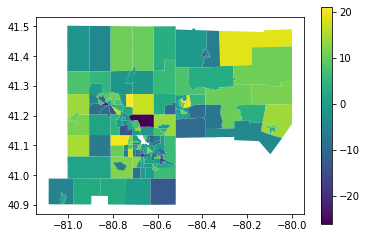

In [ ]:
# viz change in % vacancy
geo_vacancy.plot(column='change_X', legend='True')

In [ ]:
# $ (in 000s) change in median housing values

dft_values = dft_income_pop.pivot(index=['state','county','tract'], columns='year',values='B25077_001E')

dft_values = dft_values.reset_index()

dft_values['change_y'] = ((dft_values[2019] - dft_values[2009]) / dft_values[2009]) * 100

dft_values['change_y'] = dft_values['change_y'].fillna(0)

geo_values = pd.merge(dft_values, oh_pa_con,  how='inner', left_on=['state','county', 'tract'], right_on = ['STATEFP','COUNTYFP','TRACTCE'])

geo_values = geo_values[['state','county','tract',2009,2019,'change_y','geometry']]

geo_values = gpd.GeoDataFrame(geo_values)


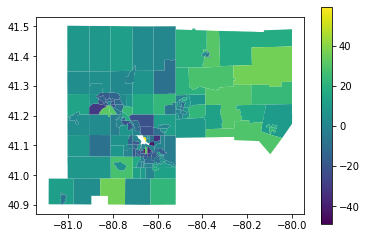

In [ ]:
#viz change in median housing values ($ in 000s)
geo_values.plot(column = 'change_y', legend = True)

In [ ]:
%%capture
pip install pysal

In [ ]:
%%capture
pip install MGWR

In [ ]:
#prep data

geo_vava = pd.merge(geo_values, geo_vacancy,  how='inner', left_on=['state','county', 'tract','geometry'], right_on = ['state','county', 'tract','geometry'])

geo_vava = geo_vava[['state', 'county','tract','geometry','change_y','change_X']]

geo_vava = gpd.GeoDataFrame(geo_vava)

In [ ]:
X = geo_vava['change_X'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = geo_vava['change_y'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X) 

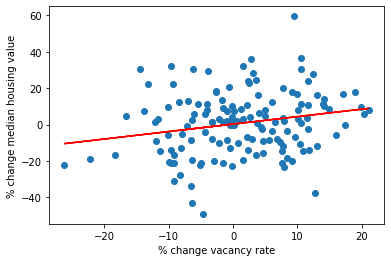

In [ ]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('% change vacancy rate')
plt.ylabel("% change median housing value")
plt.show()

In [ ]:
import libpysal as ps 
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import matplotlib as mpl

from sklearn.preprocessing import MinMaxScaler

Following the example in the MGWR git repo: https://github.com/pysal/mgwr/blob/master/notebooks/MGWR_Georgia_example.ipynb

In [ ]:
#prep data continued (incl. standardizing variables)

geo_vava['centroid'] = geo_vava.centroid
geo_vava.head()

g_y = geo_vava['change_y'].values.reshape((-1,1))
g_X = geo_vava[['change_X']].values

geo_vava["x"] = geo_vava.centroid.x
geo_vava["y"] = geo_vava.centroid.y

u = geo_vava["x"]
v = geo_vava["y"]
cs_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#calibrate MGWR

mgwr_selector = Sel_BW(cs_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(cs_coords, g_y, g_X, mgwr_selector).fit()


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[27. 81.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 154
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            146.964
Log-likelihood:                                                    -214.916
AIC:                                                                433.831
AICc:                                                               435.991
BIC:                                                               -618.653
R2:                                                                   0.046
Adj. R2:                                                              0.039

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
#Prepare MGWR results for mapping

#Add MGWR parameters to GeoDataframe
geo_vava['mgwr_intercept'] = mgwr_results.params[:,0]
geo_vava['mgwr_vava'] = mgwr_results.params[:,1]

#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

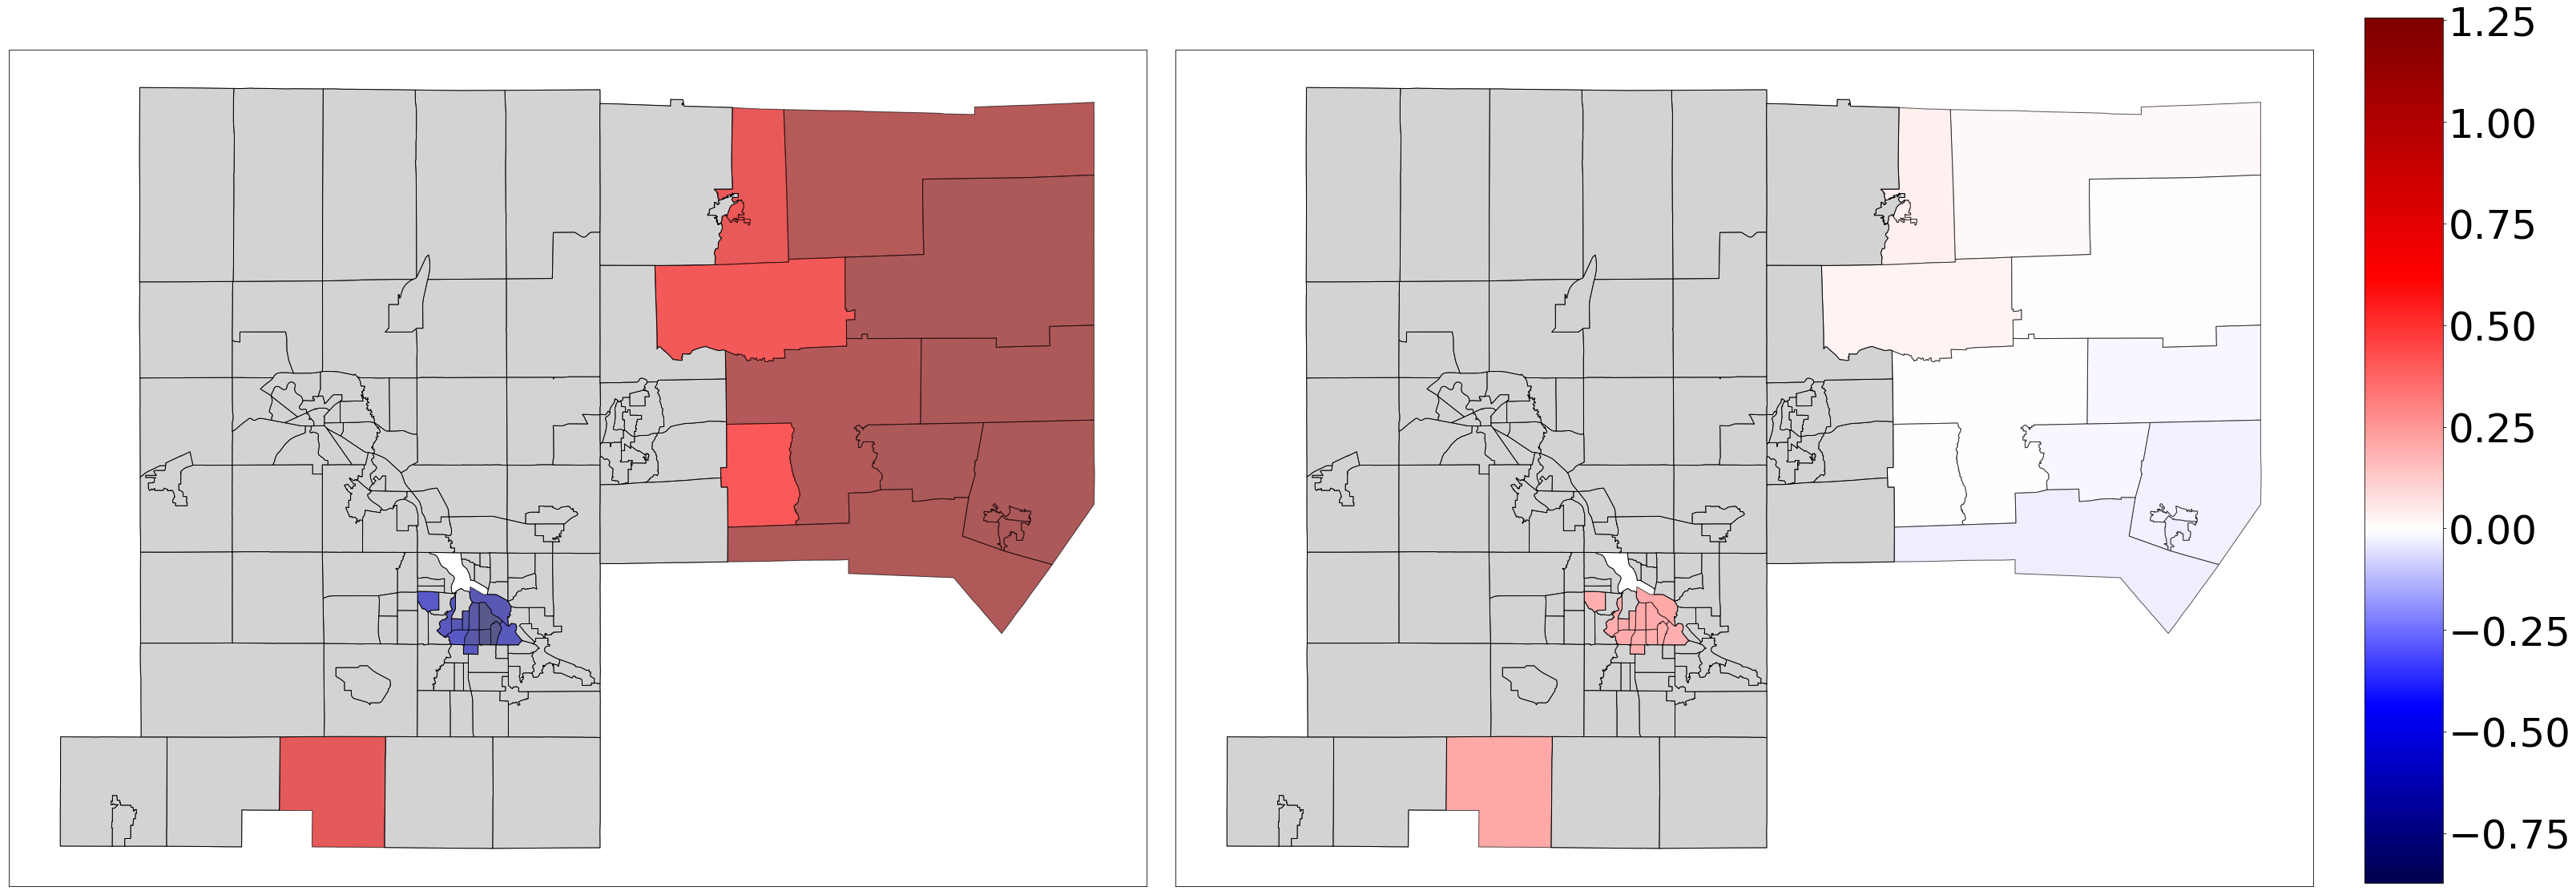

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
#ax0.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
#ax1.set_title('MGWR Intercept Surface (BW: ' + str(mgwr_bw[0]) +')', fontsize=40)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
mgwr_min = geo_vava['mgwr_intercept'].min()
mgwr_max = geo_vava['mgwr_intercept'].max()

vmin = np.min([mgwr_min, mgwr_min])
vmax = np.max([mgwr_max, mgwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot MGWR parameters intercept
geo_vava.plot('mgwr_intercept', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (mgwr_filtered_t[:,0] == 0).any():
    geo_vava[mgwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

#Plot MGWR parameters
geo_vava.plot('mgwr_vava', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (mgwr_filtered_t[:,0] == 0).any():
    geo_vava[mgwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
 
#Set figure options and plot 
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

In [ ]:
geo_vava.head()

,state,county,tract,geometry,change_y,change_X,centroid,x,y,mgwr_intercept,mgwr_vava
0,39,099,800300,"POLYGON ((-80.61635 41.09564, -80.61618 41.096...",-5.037783,-7.9,POINT (-80.60281 41.10813),-80.602813,41.108126,-0.579877,0.326570
1,39,099,800400,"POLYGON ((-80.61630 41.13324, -80.61629 41.133...",-33.853007,-6.5,POINT (-80.60231 41.12403),-80.602310,41.124031,-0.457564,0.339187
2,39,099,800500,"POLYGON ((-80.63523 41.13336, -80.63517 41.133...",-9.049774,-12.0,POINT (-80.62556 41.12206),-80.625558,41.122064,-0.327088,0.330948
3,39,099,800600,"POLYGON ((-80.63776 41.10066, -80.63752 41.101...",-43.037975,-6.3,POINT (-80.62540 41.10464),-80.625399,41.104639,-0.491063,0.322540
4,39,099,801000,"POLYGON ((-80.64635 41.08989, -80.64634 41.090...",-37.400531,12.7,POINT (-80.63823 41.08260),-80.638233,41.082603,-0.869620,0.312115


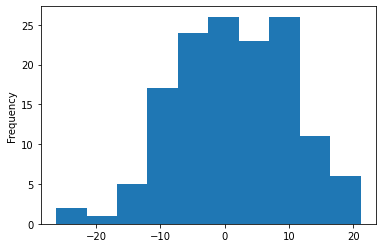

In [ ]:
#change vacancy rate
geo_vava_0 = geo_vava.loc[geo_vava['change_X'] != 0]
geo_vava_0.change_X.plot(kind = 'hist')
plt.xlabel('% change vacancy rate')

Text(0.5, 0, '% change median home value')

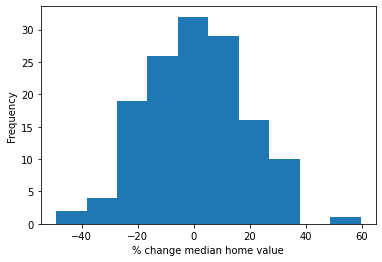

In [ ]:
geo_vava_0 = geo_vava.loc[geo_vava['change_y'] != 0]
geo_vava_0.change_y.plot(kind = 'hist')
plt.xlabel('% change median home value')

Text(0.5, 0, 'model coefficients')

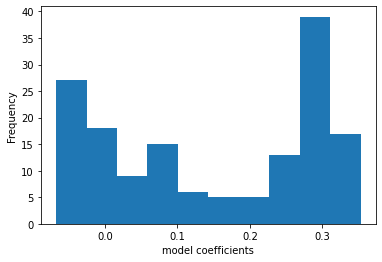

In [ ]:
#change MGWR coefficients
# geo_vava_0 = geo_vava.loc[geo_vava['change_X'] != 0]
geo_vava.mgwr_vava.plot(kind = 'hist')
plt.xlabel('model coefficients')

**Validation 

In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

regression_results(X,Y)

explained_variance:  -2.8575
r2:  -2.8596
MAE:  12.7991
MSE:  289.9724
RMSE:  17.0286
